# Regular Programming vs Machine Learning

In regular programming we process inputs and transform them to obtain outputs. For example, if I want to convert Celsius degrees to Fahrenheit degrees, I can implement the formula:

Fahrenheit = Celsius * 1.8 + 32

Then, for any value of temperature in Celsius degree, I can obtain Fahrenheit degrees.

In [1]:
def celsius_to_fahrenheit(v):
    return v * 1.8 + 32

celsius_to_fahrenheit(42)

107.60000000000001

Now, in machine learning we do not know the formula or algorithm or transformation that transforms one value into the other. All we have is examples of inputs and corresponding outputs

In [2]:
data = [
    (-40, -40.0),
    (-10, 14.0),
    (0, 32.0),
    (8, 46.4),
    (15, 59.0),
    (22, 71.6),
    (38, 100.4)
]

Then, we selected a model (in this example, a linear one), and fit it to the data. 

Note: For now, ignore all the implementation details.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Data
data = [
    (-40, -40.0),
    (-10, 14.0),
    (0, 32.0),
    (8, 46.4),
    (15, 59.0),
    (22, 71.6),
    (38, 100.4)
]

# Convert data to tensors
inputs = torch.tensor([data_point[0] for data_point in data], dtype=torch.float32).view(-1, 1)  # Celsius
targets = torch.tensor([data_point[1] for data_point in data], dtype=torch.float32).view(-1, 1)  # Fahrenheit

# Define the model
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)  # 1 input feature, 1 output feature (Fahrenheit)

    def forward(self, x):
        return self.linear(x)

model = LinearRegression()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
lossi = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    lossi.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
test_input = torch.tensor([[30.0]])  # Celsius value to convert
predicted_fahrenheit = model(test_input).item()
print(f'Predicted Fahrenheit for 30°C: {predicted_fahrenheit:.1f}')


Epoch [100/1000], Loss: 506.0889
Epoch [200/1000], Loss: 224.6265
Epoch [300/1000], Loss: 85.9769
Epoch [400/1000], Loss: 27.9029
Epoch [500/1000], Loss: 7.5872
Epoch [600/1000], Loss: 1.7162
Epoch [700/1000], Loss: 0.3214
Epoch [800/1000], Loss: 0.0496
Epoch [900/1000], Loss: 0.0063
Epoch [1000/1000], Loss: 0.0006
Predicted Fahrenheit for 30°C: 86.0


Lets take a look to how well is the network doing on each epoch

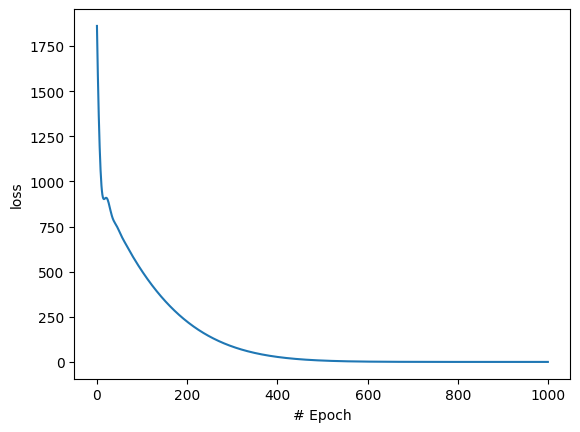

In [4]:
import matplotlib.pyplot as plt
plt.xlabel('# Epoch')
plt.ylabel('loss')
plt.plot(lossi)
plt.show()

Now, lets make some predictions

In [5]:
with torch.no_grad():
    result = model(torch.tensor([100.0]).unsqueeze(1))
print(result)

tensor([[211.9961]])


In [6]:
celsius_to_fahrenheit(100)

212.0

Lets find the errors with some random celsius values

In [7]:
celsius_test = torch.randint(-30, 150, (12,))
celsius_test

tensor([ 80,  27, -30, -30,  64, 127,  83,  57, 136,  23,  73, -26])

In [8]:
fahrenheit_test = [celsius_to_fahrenheit(c) for c in celsius_test]
print(fahrenheit_test)

[tensor(176.), tensor(80.6000), tensor(-22.), tensor(-22.), tensor(147.2000), tensor(260.6000), tensor(181.4000), tensor(134.6000), tensor(276.8000), tensor(73.4000), tensor(163.4000), tensor(-14.8000)]


In [9]:
with torch.no_grad():
    inferred_fahrenheit = model(celsius_test.to(torch.float).unsqueeze(1))
print(inferred_fahrenheit)

tensor([[175.9918],
        [ 80.5802],
        [-22.0321],
        [-22.0321],
        [147.1883],
        [260.6020],
        [181.3924],
        [134.5868],
        [276.8040],
        [ 73.3794],
        [163.3902],
        [-14.8313]])


In [10]:
mean_square_error = sum((real-inferr)**2 for real, inferr in zip(fahrenheit_test, inferred_fahrenheit))
mean_square_error

tensor([0.0044])

Lets see what the network learned so far:

In [11]:
model.linear.weight, model.linear.bias

(Parameter containing:
 tensor([[1.8002]], requires_grad=True),
 Parameter containing:
 tensor([31.9744], requires_grad=True))

Compare it with the actual equation:

Fahrenheit = Celsius * 1.8 + 32

In conclusion, we manage to build a **model** that correctly maps between Celsius degrees to Fahrenheit degrees based only in examples.

**This machine learning task is knows as Regression and we use a Linear Model**

Lets see another example with a different task. We have some rules that allow us to classify the type of an animal based on some characteristics:

- Weight > 100 kg:
    - Yes: Hair?
        - Yes: Bear
        - No: Leave on water?
            - Yes: Whale
            - No: Anaconda
    - No: Fly?
        - Yes: Eagle
        - No: Cat

This is Biology, so if I have some animal description, I can automatically find which animal it is.

In [12]:
def get_animal(weight, hair, water, fly):
    if weight > 100:
        if hair:
            return "Bear"
        else:
            if water:
                return "Whale"
            else:
                return "Anaconda"
    else:
        if fly:
            return "Eagle"
        else:
            return "Cat"

In [13]:
get_animal(120, True, False, False)

'Bear'

In [14]:
get_animal(5, True, False, False)

'Cat'

The machile learning problem appears when I have some animal descriptions together with the current type of animal, and I want to create a model that, based on the descriptions, can infer the type of animal.

First, generate the data.

In [15]:
import random

def generate_random_animals(n):    
    result = []
    for _ in range(n):
        weight = random.randint(1, 200)
        hair = random.random() > 0.5
        water = random.random() > 0.5
        fly = random.random() > 0.5
        animal = get_animal(weight, hair, water, fly)
        result.append((weight, hair, water, fly, animal))
    return result    
        
for weight, hair, water, fly, animal in generate_random_animals(5):
    print(weight, hair, water, fly, "** Animal:",  animal)

20 True True False ** Animal: Cat
88 True False False ** Animal: Cat
45 True False True ** Animal: Eagle
20 True False False ** Animal: Cat
180 False False True ** Animal: Anaconda


In [16]:
data = generate_random_animals(1000)

In [18]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [19]:
df = pd.DataFrame(data, columns=['weight', 'hair', 'water', 'fly', 'animal'])
df.head(3)

,weight,hair,water,fly,animal
0,99,False,False,True,Eagle
1,170,False,False,True,Anaconda
2,55,False,False,False,Cat


In [20]:
#split dataset in features and target variable
feature_cols = ['weight', 'hair', 'water', 'fly']
X = df[feature_cols] # Features
y = df.animal # Target variable

In [21]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [23]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [24]:
y_pred

array(['Bear', 'Eagle', 'Whale', 'Whale', 'Bear', 'Bear', 'Eagle', 'Cat',
       'Cat', 'Eagle', 'Bear', 'Whale', 'Cat', 'Eagle', 'Whale', 'Cat',
       'Whale', 'Anaconda', 'Eagle', 'Bear', 'Whale', 'Bear', 'Eagle',
       'Cat', 'Cat', 'Cat', 'Eagle', 'Cat', 'Cat', 'Eagle', 'Bear',
       'Bear', 'Cat', 'Anaconda', 'Eagle', 'Cat', 'Anaconda', 'Eagle',
       'Anaconda', 'Anaconda', 'Whale', 'Bear', 'Cat', 'Bear', 'Eagle',
       'Bear', 'Cat', 'Eagle', 'Anaconda', 'Bear', 'Cat', 'Cat', 'Bear',
       'Bear', 'Anaconda', 'Cat', 'Cat', 'Eagle', 'Eagle', 'Bear', 'Bear',
       'Whale', 'Cat', 'Bear', 'Anaconda', 'Eagle', 'Cat', 'Cat', 'Eagle',
       'Bear', 'Bear', 'Whale', 'Cat', 'Bear', 'Eagle', 'Cat', 'Eagle',
       'Eagle', 'Cat', 'Whale', 'Cat', 'Whale', 'Eagle', 'Bear', 'Eagle',
       'Cat', 'Cat', 'Whale', 'Anaconda', 'Bear', 'Eagle', 'Eagle',
       'Anaconda', 'Bear', 'Anaconda', 'Eagle', 'Eagle', 'Cat', 'Bear',
       'Whale', 'Cat', 'Eagle', 'Bear', 'Whale', 'Eagle', 'Cat'

In [25]:
[(r, p) for r, p in zip(y_test, y_pred)]

[('Bear', 'Bear'),
 ('Eagle', 'Eagle'),
 ('Whale', 'Whale'),
 ('Whale', 'Whale'),
 ('Bear', 'Bear'),
 ('Bear', 'Bear'),
 ('Eagle', 'Eagle'),
 ('Cat', 'Cat'),
 ('Cat', 'Cat'),
 ('Eagle', 'Eagle'),
 ('Bear', 'Bear'),
 ('Whale', 'Whale'),
 ('Cat', 'Cat'),
 ('Eagle', 'Eagle'),
 ('Whale', 'Whale'),
 ('Cat', 'Cat'),
 ('Whale', 'Whale'),
 ('Anaconda', 'Anaconda'),
 ('Eagle', 'Eagle'),
 ('Bear', 'Bear'),
 ('Whale', 'Whale'),
 ('Bear', 'Bear'),
 ('Eagle', 'Eagle'),
 ('Cat', 'Cat'),
 ('Cat', 'Cat'),
 ('Cat', 'Cat'),
 ('Eagle', 'Eagle'),
 ('Cat', 'Cat'),
 ('Cat', 'Cat'),
 ('Eagle', 'Eagle'),
 ('Bear', 'Bear'),
 ('Bear', 'Bear'),
 ('Cat', 'Cat'),
 ('Anaconda', 'Anaconda'),
 ('Eagle', 'Eagle'),
 ('Cat', 'Cat'),
 ('Anaconda', 'Anaconda'),
 ('Eagle', 'Eagle'),
 ('Anaconda', 'Anaconda'),
 ('Anaconda', 'Anaconda'),
 ('Whale', 'Whale'),
 ('Bear', 'Bear'),
 ('Cat', 'Cat'),
 ('Bear', 'Bear'),
 ('Eagle', 'Eagle'),
 ('Bear', 'Bear'),
 ('Cat', 'Cat'),
 ('Eagle', 'Eagle'),
 ('Anaconda', 'Anaconda'),
 ('Bear',

In [26]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


Lets take a look to the model built

In [27]:
from sklearn import tree
text_representation = tree.export_text(clf, feature_names=['weight', 'hair', 'water', 'fly'])
print(text_representation)

|--- weight <= 100.50
|   |--- fly <= 0.50
|   |   |--- class: Cat
|   |--- fly >  0.50
|   |   |--- class: Eagle
|--- weight >  100.50
|   |--- hair <= 0.50
|   |   |--- water <= 0.50
|   |   |   |--- class: Anaconda
|   |   |--- water >  0.50
|   |   |   |--- class: Whale
|   |--- hair >  0.50
|   |   |--- class: Bear



**This machine learning task is known as suppervised classification**

Lets see another example. Here we are trying to estimate the correct number from its handwritten image 

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor image with mean and standard deviation
])

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



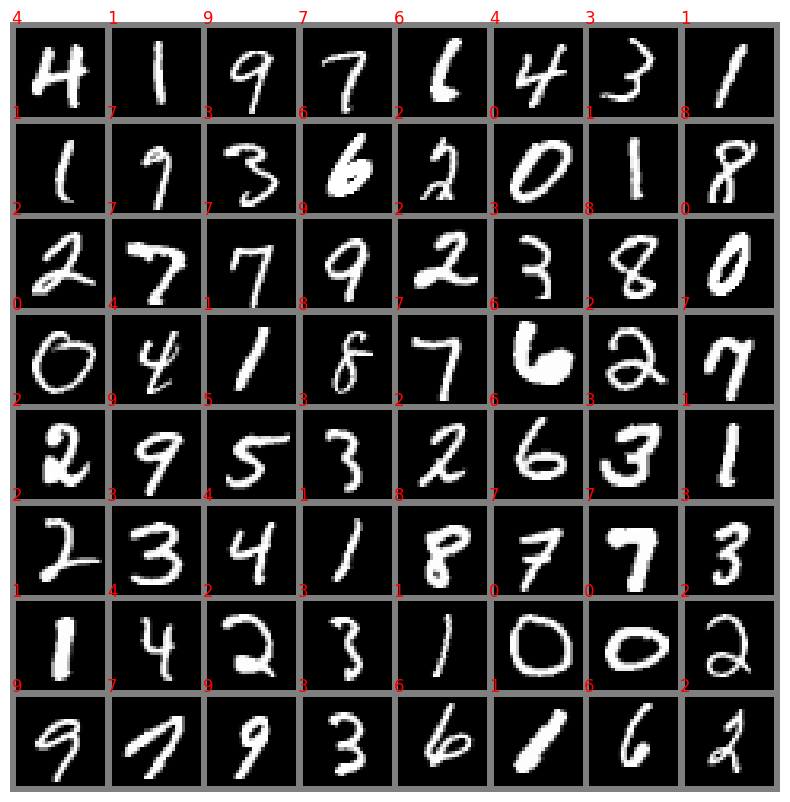

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show images with labels
def imshow_with_labels(img, labels):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Print labels near each image
    num_images = len(labels)
    grid_size = int(np.sqrt(num_images))
    for i in range(num_images):
        plt.text((i % grid_size) * 30, (i // grid_size) * 30, str(labels[i].item()), color='red', fontsize=12)

    plt.axis('off')
    plt.show()

# Get some random training images and their labels
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images with labels
imshow_with_labels(torchvision.utils.make_grid(images), labels)


In [30]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [31]:
trainset.targets[0], trainset.data[0], 

(tensor(5),
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   

For solving this classification problem in a traditional way, we need to figure out and then calculate some "features" that differenciate from one class to the other. For example, one can be the total sum of elements on each image.

<Figure size 1000x600 with 0 Axes>

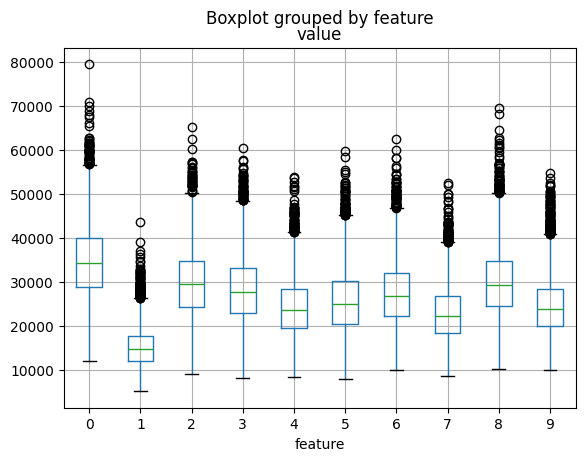

In [32]:
import pandas as pd

data = pd.DataFrame({
    'feature': trainset.targets,
    'value': torch.sum(trainset.data, axis=(1, 2)).numpy()
})

plt.figure(figsize=(10, 6))
data.boxplot(column='value', by='feature')
plt.show()

We can see that we can use this feature to differentiate between categories, but there is a lot of overlapping. Lets manufacture another feature, for example, the symmetries.

<Figure size 1000x600 with 0 Axes>

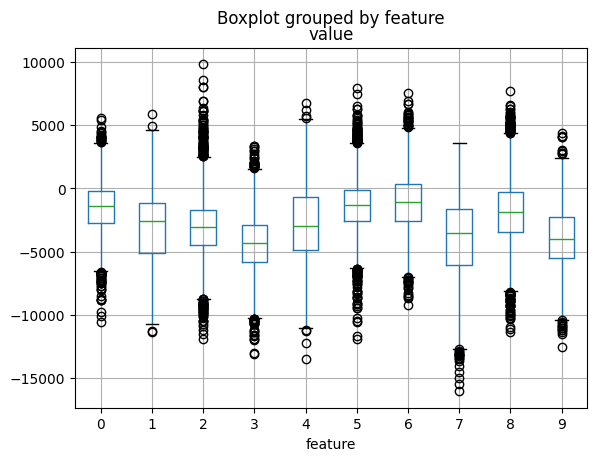

In [33]:
# Vertical Symmetry

data = pd.DataFrame({
    'feature': trainset.targets,
    'value': (torch.sum(trainset.data[:, :, :14], axis=(1, 2)) - 
              torch.sum(trainset.data[:, :, 14:], axis=(1, 2))
              ).numpy()
})

# Create the box plot
plt.figure(figsize=(10, 6))
data.boxplot(column='value', by='feature')
plt.show()

<Figure size 1000x600 with 0 Axes>

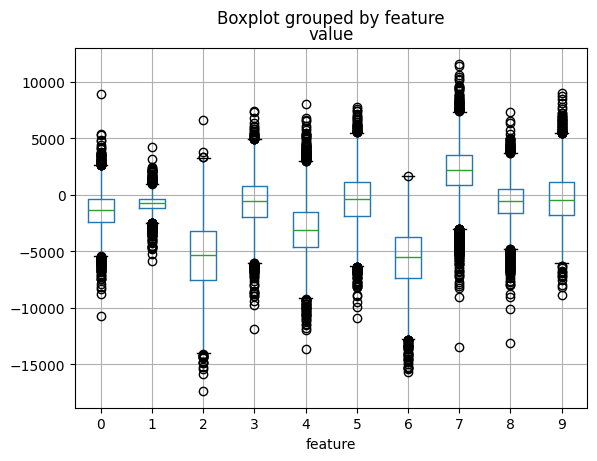

In [34]:
data = pd.DataFrame({
    'feature': trainset.targets,
    'value': (torch.sum(trainset.data[:, :14, :], axis=(1, 2)) - 
              torch.sum(trainset.data[:, 14:, :], axis=(1, 2))
              ).numpy()
})

plt.figure(figsize=(10, 6))
data.boxplot(column='value', by='feature')
plt.show()

We can now try to find some rules that allow us to classify each image, using the three manufactured features.

The machine learning way is different. We create a model that can learn the relations, fit the model using available data, and then use the fitted model to classify digits.

In [35]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [37]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")
print('Finished Training')


Epoch 1, Loss: 0.4301750638337532
Epoch 2, Loss: 0.17661378379942957
Epoch 3, Loss: 0.13194213880361047
Epoch 4, Loss: 0.10473726895143355
Epoch 5, Loss: 0.08433929778564014
Finished Training


In [38]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')


Accuracy of the network on the 10000 test images: 96.77%


In [39]:
dataiter = iter(testloader)
images, labels = dataiter.next()

outputs = model(images)
_, predicted = torch.max(outputs, 1)

for l, p in zip(labels, predicted):
    print(l, p)


tensor(7) tensor(7)
tensor(2) tensor(2)
tensor(1) tensor(1)
tensor(0) tensor(0)
tensor(4) tensor(4)
tensor(1) tensor(1)
tensor(4) tensor(4)
tensor(9) tensor(9)
tensor(5) tensor(6)
tensor(9) tensor(9)
tensor(0) tensor(0)
tensor(6) tensor(6)
tensor(9) tensor(9)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(5) tensor(5)
tensor(9) tensor(9)
tensor(7) tensor(7)
tensor(3) tensor(3)
tensor(4) tensor(4)
tensor(9) tensor(9)
tensor(6) tensor(6)
tensor(6) tensor(6)
tensor(5) tensor(5)
tensor(4) tensor(4)
tensor(0) tensor(0)
tensor(7) tensor(7)
tensor(4) tensor(4)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(3) tensor(3)
tensor(1) tensor(1)
tensor(3) tensor(3)
tensor(4) tensor(0)
tensor(7) tensor(7)
tensor(2) tensor(2)
tensor(7) tensor(7)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(7) tensor(7)
tensor(4) tensor(4)
tensor(2) tensor(2)
tensor(3) tensor(3)
tensor(5) tensor(5)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(4) tensor(4)
tensor(4) tensor(4)


You can see that the problem was almost perfectly solved, with no need to manually engineering the features.

**This task is also a suppervised classification, but using images as inputs**

Lets see a final example. The manager of a chain of stores wants to understand the behavior of their customers in order to direct advertising campaigns to similar subsets of customers.

The available data includes: gender, age, annual income, and a score between 0 and 100 that evaluates the magnitude of purchases.

In [40]:
df = pd.read_csv("data/Mall_Customers.csv", index_col='CustomerID')
df.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


First, we simplify the name of some columns

In [41]:
df.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score'}, inplace=True)
df.head()

,Gender,Age,Income,Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Now, we will try to understand data using pairplots

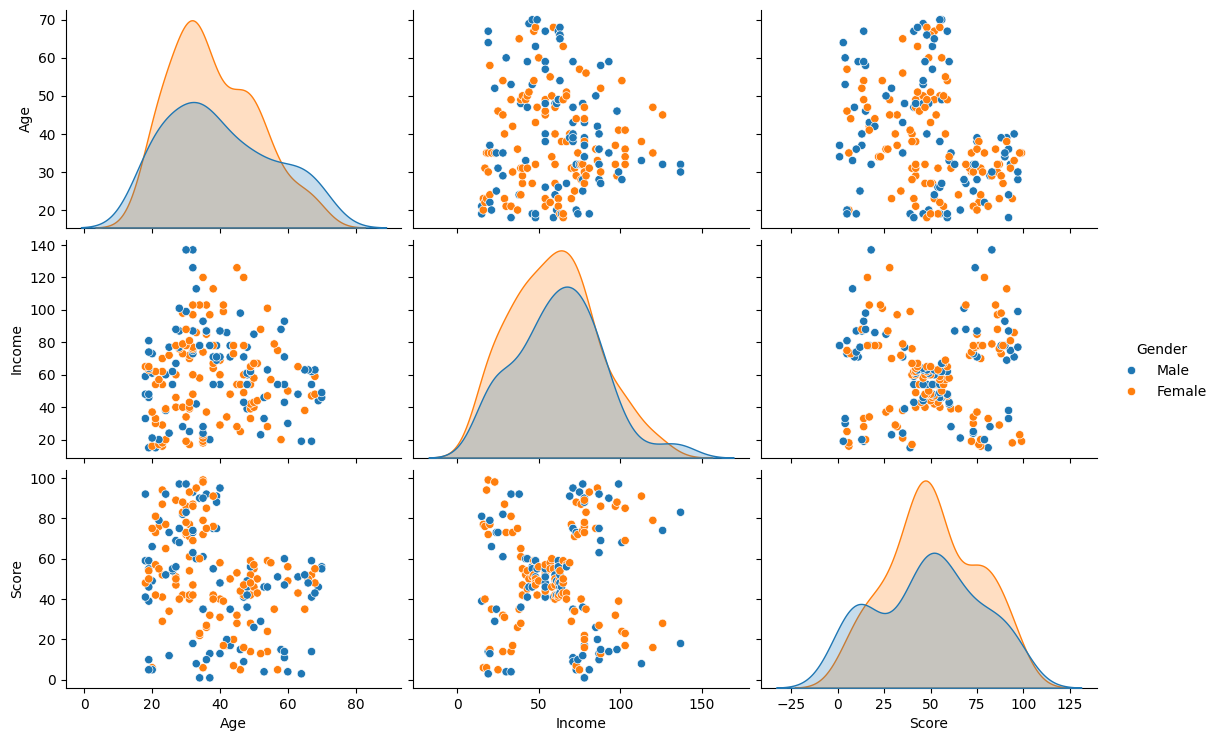

In [42]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.pairplot(df, hue='Gender', aspect=1.5)
plt.show()

We conclude that gender is not important and can be removed from data

In [43]:
X = df.drop(['Gender'], axis=1)
X.head()

,Age,Income,Score
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40


We will use the KMeans clustering algorithm, which decomposes the dataframe into groups of objects that are very similar to each other and dissimilar to the objects in other groups. As a result, we also obtain a representative object for each group, which is the object most similar to the others.

This algorithm takes the number of desired groups (k) as a parameter. Lets try with k=3

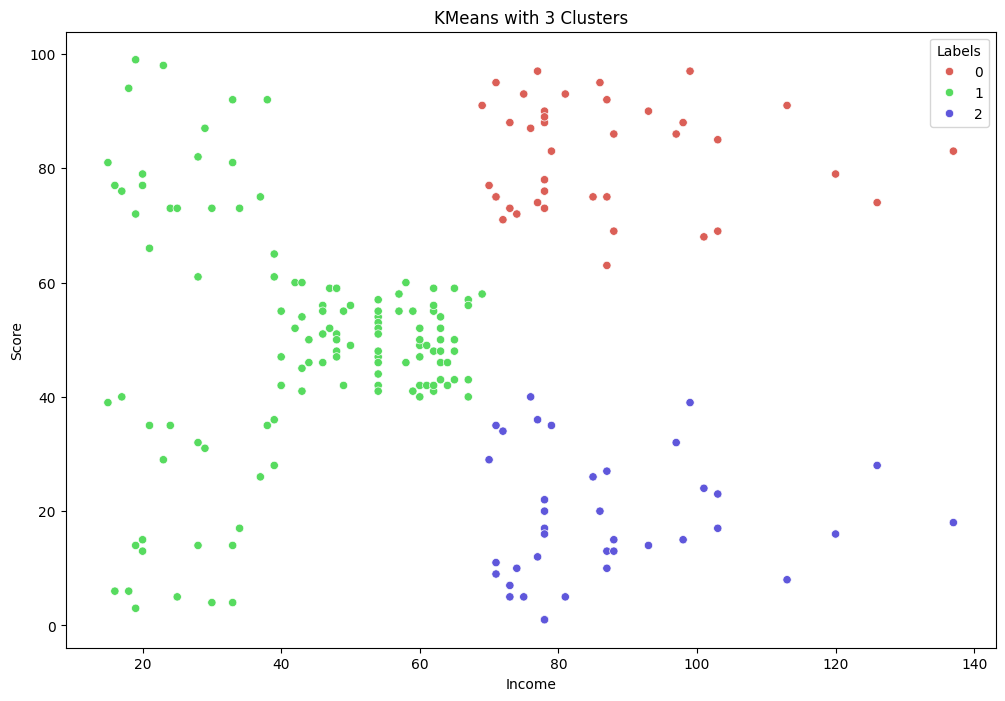

In [44]:
from sklearn.cluster import KMeans

km3 = KMeans(n_clusters=3, n_init="auto", random_state=314).fit(X)

X['Labels'] = km3.labels_
plt.figure(figsize=(12, 8))
sn.scatterplot(x=X['Income'], y=X['Score'], hue=X['Labels'], 
                palette=sn.color_palette('hls', 3))
plt.title('KMeans with 3 Clusters')
plt.show()

Lets test what happen with k values from  2 to 10

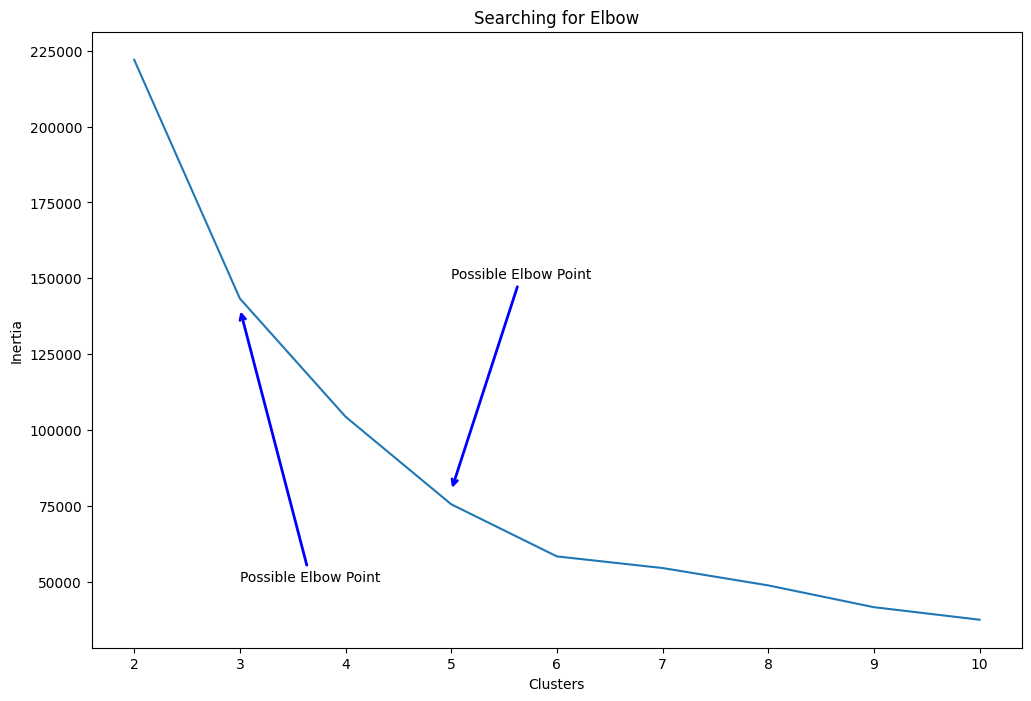

In [45]:
clusters = []

for i in range(2, 11):
    km = KMeans(n_clusters=i, n_init="auto", random_state=314).fit(X)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sn.lineplot(x=list(range(2, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy=(3, 140000), xytext=(3, 50000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

So, lets test with k = 5.

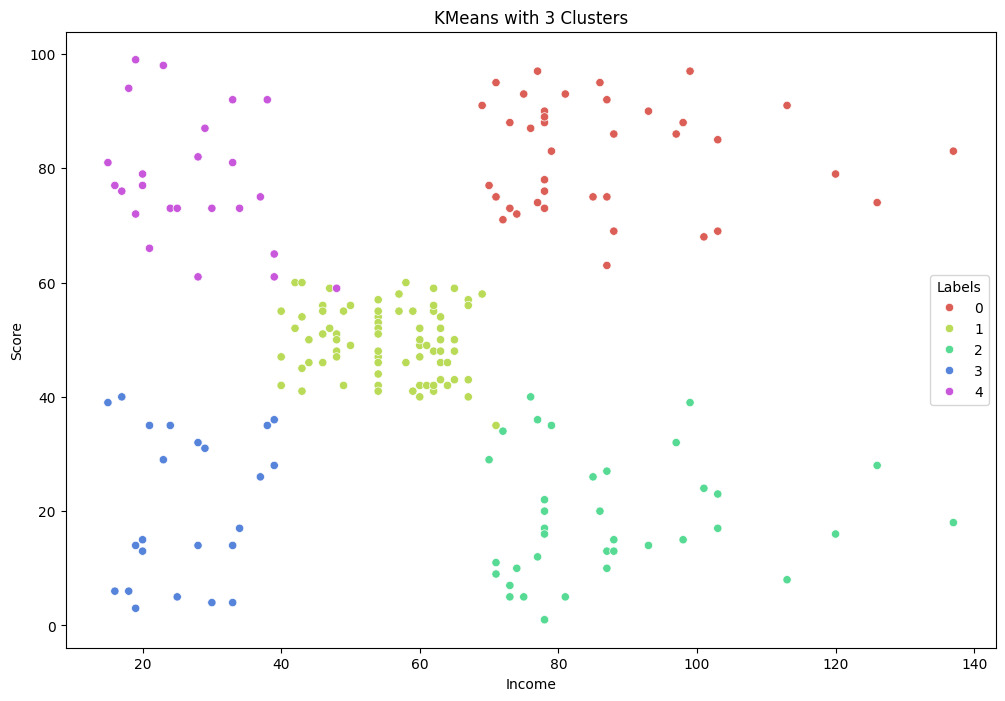

In [46]:
km5 = KMeans(n_clusters=5, n_init="auto", random_state=314).fit(X)

X['Labels'] = km5.labels_
plt.figure(figsize=(12, 8))
sn.scatterplot(x=X['Income'], y=X['Score'], hue=X['Labels'], 
                palette=sn.color_palette('hls', 5))
plt.title('KMeans with 3 Clusters')
plt.show()

The results with k=5 are better that with k=3. 

**Note** the highly subjective nature of this evaluation, as unlike previous examples, here we do not have prior knowledge to perform an objective evaluation.

The 5 obtained clusters can be explained as follows:

    Label 0: high income and low expenses
    Label 1: low income and expenses
    Label 2: high income and expenses
    Label 3: average income and expenses
    Label 4: low income and high expenses

In conclusion, the client can notice that there is a segment with high income and low expenses, to which they could direct a more aggressive advertising strategy and potentially achieve good results.

Another conclusion is that there is a segment that spends more than their income, which is interesting to consider.

**This type of machine learning task is known as clustering**

## Conclusion
- In regular programming, we provide the algorithm or formula to transform the inputs in outputs
- In machine learning, we provide examples of inputs and its corresponding outputs, and make the algorithms to figure out a good model for doing the transformation
    - There are different models for performing each task
    - Every model has different parameters that impacts the quality of the results
    - Selecting the best option is a combination of experience and a trial-and-error strategy.

# Próxima actividad
- Presentación de proyecto finales anteriores y otras ideas
- Exposición individual sobre posibles proyectos finales (venir preparado!)